First, let's read in our data.

In [28]:
import pandas as pd

# Inline
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data.csv")

df.head()

,Date,a/b Open,a/b Close,b/c open,b/c close,a/c open,a/c close
0,1/1/10,11.035,11.0350,13.66,13.6350,12.900,12.885
1,1/4/10,11.115,11.0500,13.66,13.6850,12.950,13.000
2,1/5/10,11.040,10.5900,13.69,13.3200,13.000,12.650
3,1/6/10,10.595,10.5425,13.38,12.9025,12.715,12.495
4,1/7/10,10.545,10.6375,12.95,13.1000,12.580,12.270


Here's the result of `df.describe()` on our data.

In [29]:
df.describe()

,a/b Open,a/b Close,b/c open,b/c close,a/c open,a/c close
count,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000
mean,9.916023,9.897449,9.935126,9.926391,11.852176,11.852465
std,2.686881,2.694516,2.271425,2.276009,2.953024,2.952725
min,4.157500,4.165000,4.450000,4.450000,4.347500,4.315000
25%,7.875000,7.820000,8.350000,8.312500,10.005000,9.990000
50%,9.755000,9.745000,9.960000,9.945000,11.592500,11.575000
75%,11.930000,11.915000,11.440000,11.425000,13.812500,13.800000
max,17.830000,17.735000,17.430000,17.430000,24.155000,23.887500


Next, let's define a method to predict a normal distribution based on the joint distribution of two different normal distributions using Monte Carlo simulation. This is what we will use to predict a/c open.

Let $N_1(0, \sigma_1)$ and $N_2(0, \sigma_2)$ be the normal distributions of a/b, b/c respectively.

Let $s_1 \in N_1$, $s_2 \in N_2$ be randomly chosen.

So the returns are $r_1 = e^{s_1} - 1$, $r_2 = e^{s_2} - 1$.

So $r_3$, the expected return, is $r_3 = (1 + r_1) * (1 + r_2) - 1$.

In [30]:
import numpy as np

def random_return(mu_1, sigma_1, mu_2, sigma_2):
    """Random return of two distributions."""
    rand_1 = np.random.normal(mu_1, sigma_1)
    rand_2 = np.random.normal(mu_2, sigma_2)
    return np.exp(rand_1) * np.exp(rand_2) - 1


def monte_carlo_distribution(mu_1, sigma_1, mu_2, sigma_2, iterations=1000):
    """Returns a distribution generated by a Monte Carlo simulation."""
    dist = [random_return(mu_1, sigma_1, mu_2, sigma_2) for x in range(iterations)]
    return pd.DataFrame(dist)

Now, let's predict our a/c open given a/b open and b/c open.

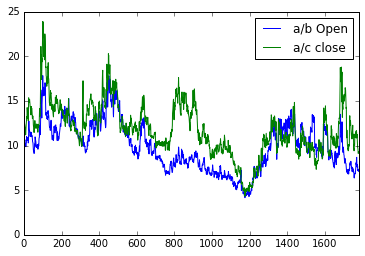

In [61]:
df[['a/b Open', 'a/c close']].plot()

In [91]:
row = df.iloc[0]

ab_open = row['a/b Open'] / 100
bc_open = row['b/c open'] / 100

ab = np.random.normal(0, ab_open, size=1000)
bc = np.random.normal(0, bc_open, size=1000)

abd = pd.DataFrame(ab)
bcd = pd.DataFrame(bc)

dist = monte_carlo_distribution(0, ab_open, 0, bc_open, 1000)

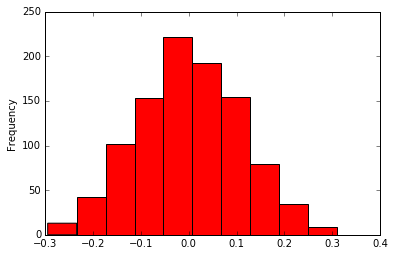

In [102]:
abd.plot(kind='hist', color='#ff0000', legend=False)

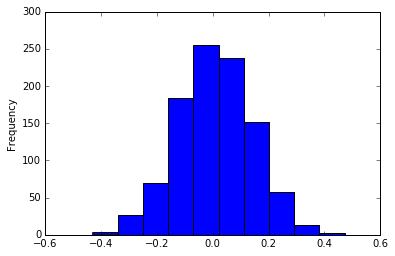

In [103]:
bcd.plot(kind='hist', color='#0000ff', legend=False)

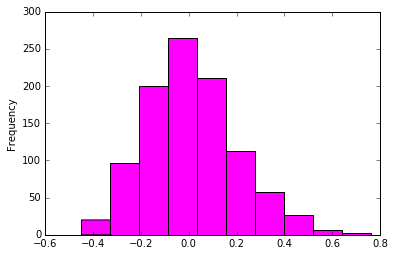

In [104]:
dist.plot(kind='hist', color='#ff00ff', legend=False)

In [49]:
def predict_ac_open(ab_open, bc_open):
    dist = monte_carlo_distribution(0, ab_open / 100, 0, bc_open / 100, 1000)
    return float(dist.std() * 100)

def predict_row(row):
    ab_open = row['a/b Open']
    bc_open = row['b/c open']
    ac_open = row['a/c open']
    ac_close = row['a/c close']
    expected_open = predict_ac_open(ab_open, bc_open)
    diff = expected_open - ac_open
    should_buy = expected_open > ac_open
    close_open_diff = ac_close - ac_open
    
    success = (close_open_diff >= 0 and should_buy) \
        or (close_open_diff < 0 and not should_buy)
        
    return {
        'expected_open': expected_open,
        'actual_open': ac_open,
        'actual_close': ac_close,
        'buy': 1 if should_buy else 0,
        'success': 1 if success else 0,
        'diff': diff,
        'diff_pct': diff / ac_open * 100,
        'close_open_diff': close_open_diff,
    }
    

results = pd.DataFrame([predict_row(row) for index, row in df.iterrows()])
results.head()

,actual_close,actual_open,buy,close_open_diff,diff,diff_pct,expected_open,success
0,12.885,12.900,1,-0.015,5.640642,43.725908,18.540642,0
1,13.000,12.950,1,0.050,5.288378,40.836897,18.238378,1
2,12.650,13.000,1,-0.350,4.959245,38.148037,17.959245,0
3,12.495,12.715,1,-0.220,4.514260,35.503420,17.229260,0
4,12.270,12.580,1,-0.310,4.196692,33.360033,16.776692,0


In [53]:
results.describe()

,actual_close,actual_open,buy,close_open_diff,diff,diff_pct,expected_open,success
count,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000
mean,11.852465,11.852176,0.967996,0.000289,2.585939,23.790148,14.438114,0.475014
std,2.952725,2.953024,0.176061,0.558560,1.490482,14.827213,2.992065,0.499516
min,4.315000,4.347500,0.000000,-3.392500,-1.748743,-8.892348,6.208984,0.000000
25%,9.990000,10.005000,1.000000,-0.275000,1.447761,12.003894,12.515883,0.000000
50%,11.575000,11.592500,1.000000,-0.022500,2.565235,22.302555,14.673659,0.000000
75%,13.800000,13.812500,1.000000,0.225000,3.692651,34.568999,16.380501,1.000000
max,23.887500,24.155000,1.000000,3.947500,7.017519,72.029852,25.763508,1.000000


In [56]:
results[['diff', 'diff_pct', 'buy', 'success']].describe()

,diff,diff_pct,buy,success
count,1781.000000,1781.000000,1781.000000,1781.000000
mean,2.585939,23.790148,0.967996,0.475014
std,1.490482,14.827213,0.176061,0.499516
min,-1.748743,-8.892348,0.000000,0.000000
25%,1.447761,12.003894,1.000000,0.000000
50%,2.565235,22.302555,1.000000,0.000000
75%,3.692651,34.568999,1.000000,1.000000
max,7.017519,72.029852,1.000000,1.000000


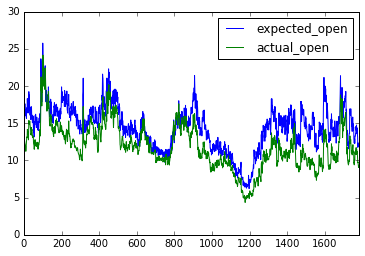

In [60]:
results[['expected_open', 'actual_open']].plot()

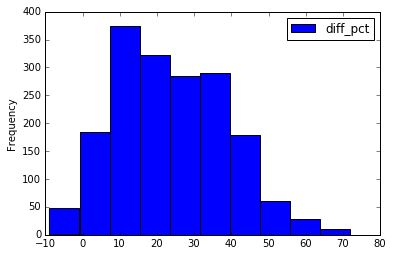

In [52]:
results[['diff_pct']].plot(kind='hist')

This is inconclusive -- actually worse. Success rate is ~50%.